# RandomForestClassifier

$ pip install graphviz

In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import random
random.seed(2024)

In [2]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Load data file
uq_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5" 
train_x_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_testY.csv")
test_x_df

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,5.994013,175.26022,9.389342,160.19148,12.411823,-2.771648,-0.577210,0.571201,2.757304,-0.052158,...,8.502358,131.625,39.500,16.500,4.875,0.000,0.000,2284,0.679245,2.566038
1,8.143989,172.74998,8.340377,158.41364,10.510427,-2.761202,-0.605943,0.736091,2.765514,-0.048581,...,11.167808,314.375,84.125,29.750,5.875,0.125,0.000,6535,0.780822,2.821918
2,7.558447,275.62744,10.419536,185.81779,15.728617,-2.267313,-0.722016,0.690390,2.228887,-0.064243,...,12.732143,115.250,17.500,6.000,2.125,0.000,0.000,1462,1.200000,3.885714
3,7.640180,209.40883,9.224951,131.75505,11.913830,-2.534188,-0.638915,0.706667,2.705784,-0.055374,...,9.086735,94.375,19.375,8.625,3.500,0.750,0.000,2904,0.877551,3.183673
4,10.034180,194.92766,11.159462,154.57048,14.929475,-2.472854,-0.686740,0.731408,2.491220,-0.059509,...,15.618902,214.250,54.125,22.500,6.500,0.875,0.000,1705,1.048780,3.560976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,9.364868,148.06656,9.751122,122.57384,11.608300,-2.537512,-0.599106,0.504315,2.707295,-0.041365,...,9.369318,173.875,60.000,29.625,13.875,5.125,0.375,4841,0.833333,2.787879
244,9.508312,134.60069,8.863824,177.13689,11.547717,-2.665385,-0.478010,0.442054,2.647204,-0.042139,...,9.153409,164.750,28.250,10.250,2.625,0.000,0.000,3842,0.969697,2.939394
245,8.014165,278.35916,9.845626,181.29170,13.266225,-2.441787,-0.582110,0.593952,2.439651,-0.046212,...,11.514151,157.250,27.875,10.250,3.000,0.125,0.000,3401,1.000000,3.433962
246,9.103675,200.99684,9.508262,174.29413,12.149082,-2.566612,-0.600858,0.577008,2.714610,-0.042108,...,8.604167,140.750,33.000,12.875,3.750,0.250,0.000,5121,0.909091,2.969697


In [4]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

print(train_x.shape)
print(train_y.shape)

(989, 306)
(989,)


In [5]:
# Construct a RF classification model

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_x, train_y)
 
# performing predictions on the test dataset
test_pred_y = clf.predict(test_x)




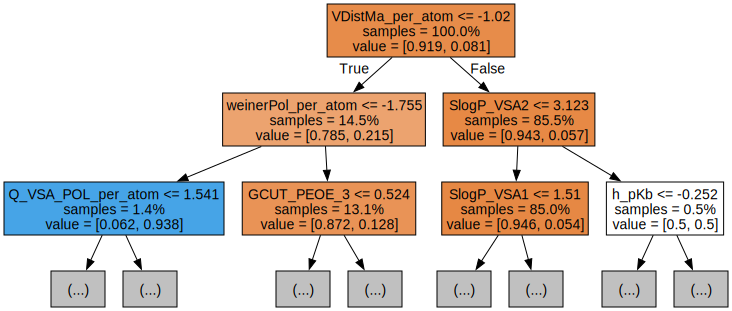

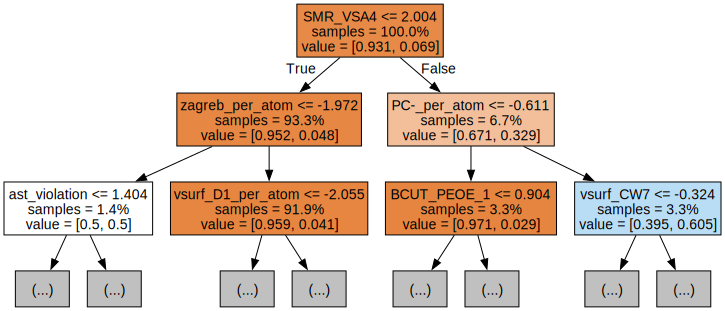

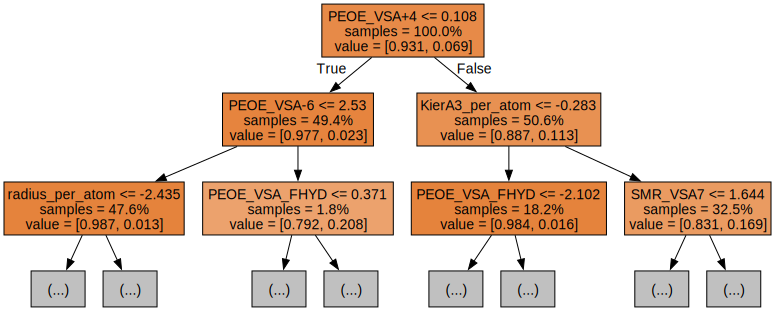

In [6]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[228   0]
 [ 16   4]]


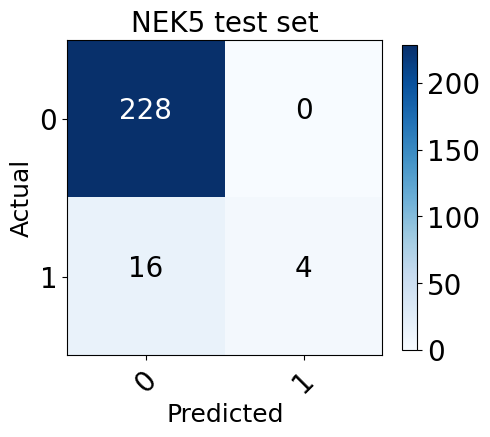

In [7]:
# Create the confusion matrix
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


## Hyperparameter tuning

In [8]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,50)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x289ad73d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2abada7f0>})

In [9]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 39, 'n_estimators': 369}


Confusion matrix, without normalization
[[227   1]
 [ 16   4]]


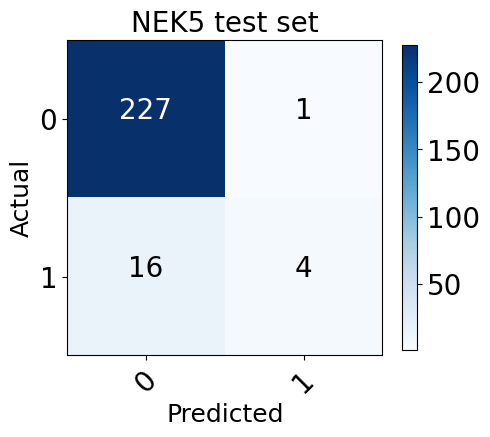

In [10]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
